In [1]:
from train import *
import warnings
warnings.filterwarnings('ignore', 'The parameter \'pretrained\' is deprecated')
warnings.filterwarnings('ignore', 'Arguments other than a weight enum or `None` for \'weights\' are deprecated')

c:\Users\11709\anaconda3\python.exe


Define arguments

In [30]:
def init_args() -> ARGUMENTS:
    args = ARGUMENTS(
        model_type="FASHION_VGG3",
        normal_class=1,
        num_ref=10,
        num_ref_eval=5,
        lr=1e-4,
        vector_size=1024,
        weight_decay=0.001, #done
        seed=1001,
        weight_init_seed=1001,
        alpha=0.15, # done
        k=3,
        epochs=10,
        contamination=0, # done
        batch_size=1,
        biases=1,
        dataset='fashion',
        distance_method='multi'
    )
    return args

def analyze_result(results: dict, feature_name: str, selected_performances: list = None):
    plt.figure(figsize=(10, 8))
    markers = ['o', 's', 'D', 'x', '^', 'v', '<', '>', 'p', 'h', '+', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
    for key, value in results.items():
        if key == 'df': continue
        if selected_performances is not None and key not in selected_performances:
            continue
        plt.plot(value, label=key, marker=markers.pop(0))
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.title(f"Performance along {feature_name}")
    plt.grid()

def plot_hist(results: dict):
    # select the best index according to the f1 score
    best_index = np.argmax(results['f1'])
    tmp_df = results['df'][best_index]
    plt.figure(figsize=(10, 8))
    thres = np.percentile(tmp_df["minimum_dists"], 10)
    for label in tmp_df["label"].unique():
        plt.hist(tmp_df[tmp_df["label"] == label]["minimum_dists"], alpha=0.5, label=label, bins=100)
    plt.axvline(x=thres, color="r", linestyle="--")
    plt.ylabel('Count')
    plt.xlabel('Anomaly Score')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.title("Anomaly Score Distribution")
    plt.grid()


args = init_args()

## Do light experiment

In [32]:
args = init_args()
df, auc, f1, precision, recall, acc = train(args, 200) #f1: 0.927

auc: 0.9906, f1: 0.9802, spec: 0.7407, recall: 1.0000, acc: 0.8704


## Find the best hyperparameters

## Do experiment along class

In [5]:
results_class = {}
results_class['df'], results_class['auc'], results_class['f1'], results_class['spec'], results_class['recall'], results_class['acc'] = [], [], [], [], [], []
class_range = range(10)
for normal_class in class_range:
    args = init_args()
    args.normal_class = normal_class
    df, auc, f1, spec, recall, acc = train(args)
    results_class['df'].append(df)
    results_class['auc'].append(auc)
    results_class['f1'].append(f1)
    results_class['spec'].append(spec)
    results_class['recall'].append(recall)
    results_class['acc'].append(acc)

auc: 0.9574, f1: 0.9565, spec: 0.6667, recall: 0.9362, acc: 0.8014
auc: 1.0000, f1: 0.9773, spec: 0.7143, recall: 1.0000, acc: 0.8571
auc: 0.8750, f1: 0.9213, spec: 0.3333, recall: 0.9318, acc: 0.6326
auc: 0.9333, f1: 0.9556, spec: 0.6000, recall: 0.9556, acc: 0.7778
auc: 0.8089, f1: 0.9333, spec: 0.4000, recall: 0.9333, acc: 0.6667
auc: 0.9457, f1: 0.9670, spec: 0.7500, recall: 0.9565, acc: 0.8533
auc: 0.8400, f1: 0.9556, spec: 0.6000, recall: 0.9556, acc: 0.7778
auc: 0.9502, f1: 0.9545, spec: 0.5714, recall: 0.9767, acc: 0.7741
auc: 0.8370, f1: 0.9451, spec: 0.5000, recall: 0.9348, acc: 0.7174
auc: 0.9891, f1: 0.9890, spec: 1.0000, recall: 0.9783, acc: 0.9891


In [ ]:
plot_hist(results_class)
analyze_result(results_class, "class")

## Do experiment along epochs

In [ ]:
result_epochs = {}
result_epochs['df'], result_epochs['auc'], result_epochs['f1'], result_epochs['spec'], result_epochs['recall'], result_epochs['acc'], result_epochs['dataset'] = [], [], [], [], [], [], []
epochs_range = np.arange(1, 31, 5)
for i, epochs in enumerate(epochs_range):
    args = init_args()
    args.epochs = epochs
    df, auc, f1, spec, recall, acc = train(args)
    result_epochs['df'].append(df)
    result_epochs['auc'].append(auc)
    result_epochs['f1'].append(f1)
    result_epochs['spec'].append(spec)
    result_epochs['recall'].append(recall)
    result_epochs['acc'].append(acc)

In [ ]:
analyze_result(result_epochs, "epochs")
plot_hist(result_epochs)

## Do experiment along alpha

In [9]:
results_alpha = {}
results_alpha['df'], results_alpha['auc'], results_alpha['f1'], results_alpha['spec'], results_alpha['recall'], results_alpha['acc'] = [], [], [], [], [], []
alpha_range = np.arange(0, 1.1, 0.1)
for alpha in alpha_range:
    args = init_args()
    args.alpha = alpha
    df, auc, f1, spec, recall, acc = train(args)
    results_alpha['df'].append(df)
    results_alpha['auc'].append(auc)
    results_alpha['f1'].append(f1)
    results_alpha['spec'].append(spec)
    results_alpha['recall'].append(recall)
    results_alpha['acc'].append(acc)

In [ ]:
analyze_result(results_alpha, "alpha")
plot_hist(results_alpha)

## Do experiment along contamination

In [ ]:
results_contamination = {}
results_contamination['df'], results_contamination['auc'], results_contamination['f1'], results_contamination['spec'], results_contamination['recall'], results_contamination['acc'] = [], [], [], [], [], []
contamination_range = np.arange(0, 0.5, 0.05)
for contamination in contamination_range:
    args = init_args()
    args.contamination = contamination
    df, auc, f1, spec, recall, acc = train(args, 100)
    results_contamination['df'].append(df)
    results_contamination['auc'].append(auc)
    results_contamination['f1'].append(f1)
    results_contamination['spec'].append(spec)
    results_contamination['recall'].append(recall)
    results_contamination['acc'].append(acc)

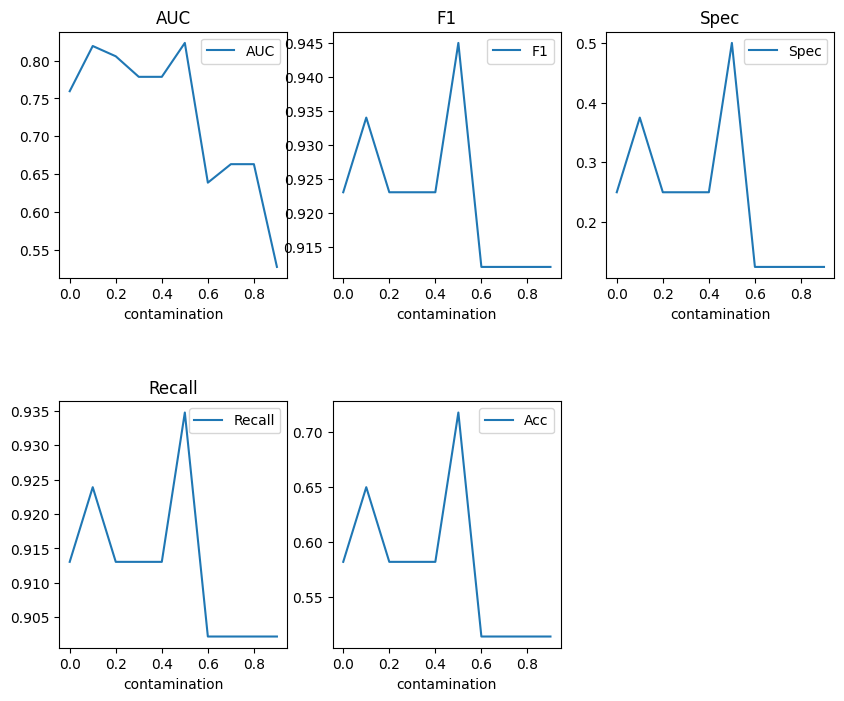

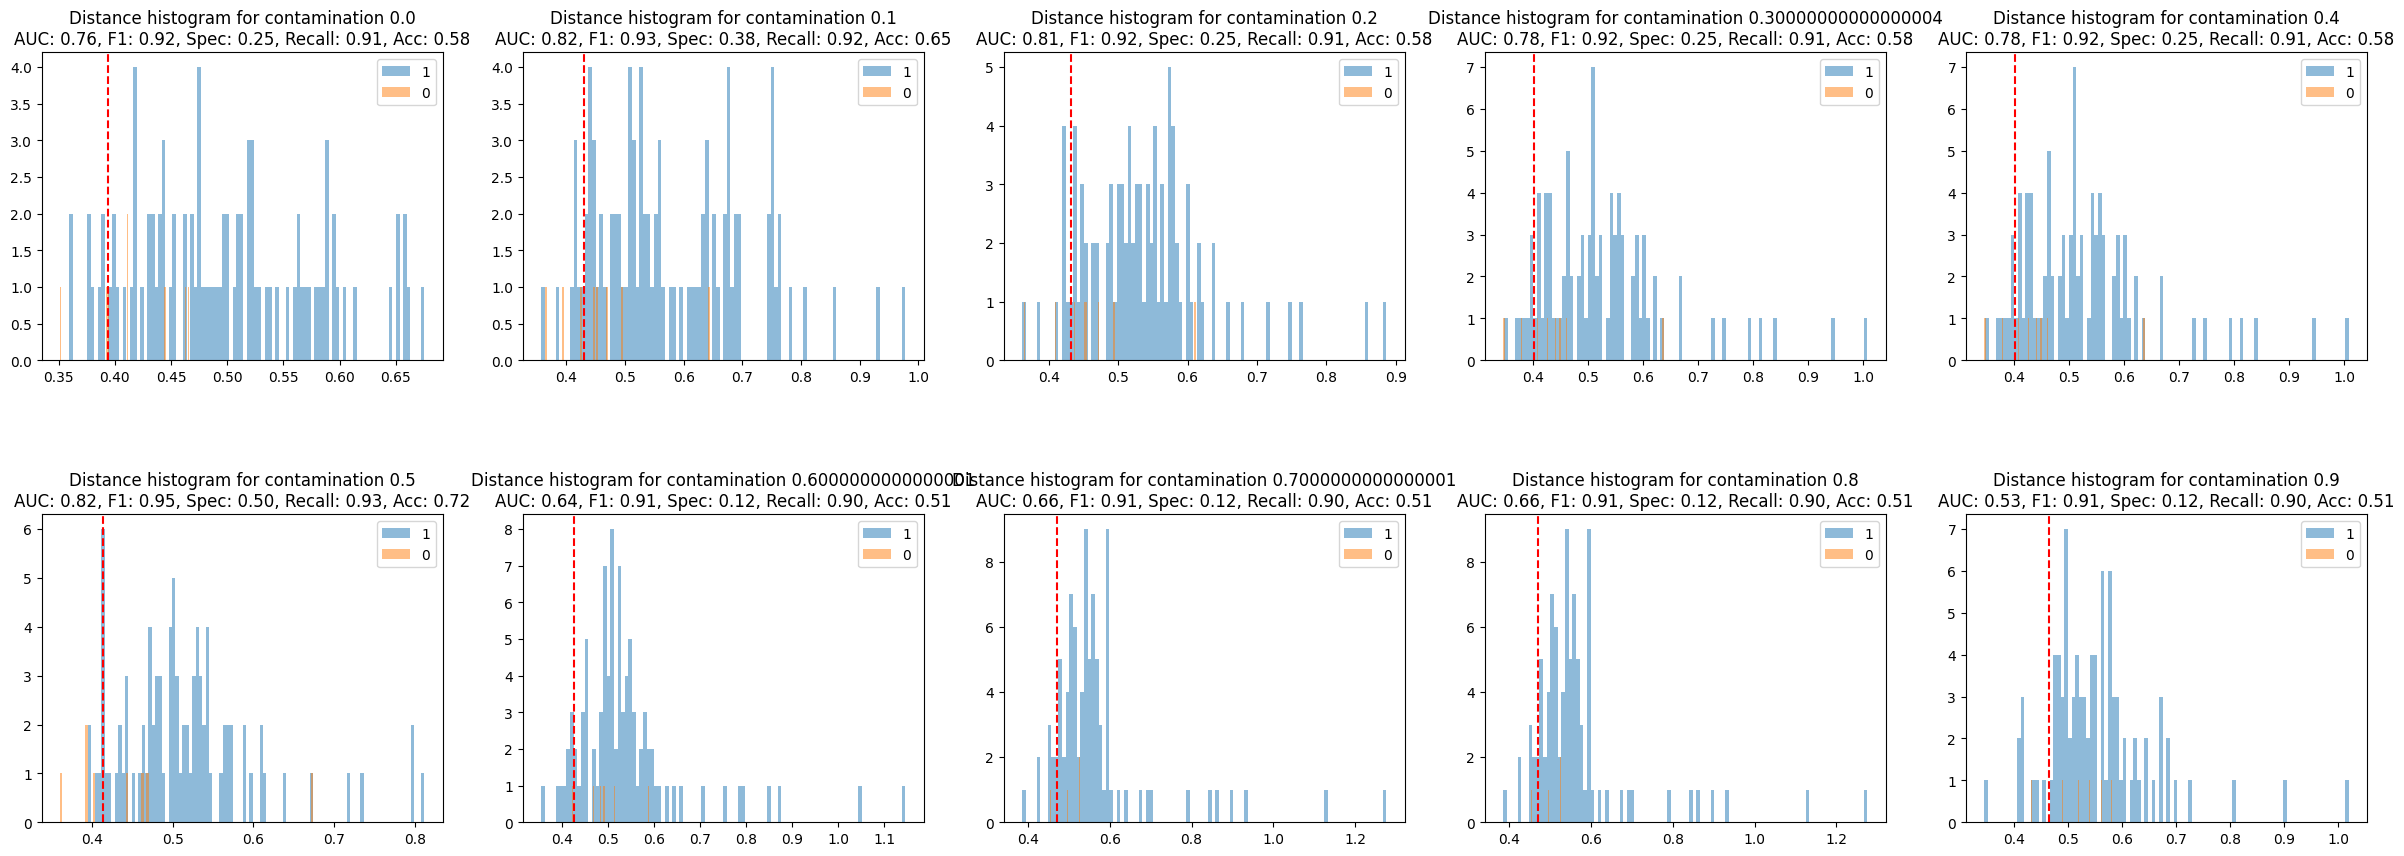

In [5]:
analyze_result(results_contamination, "contamination")
plot_hist(results_contamination)

## Do experiment along train dataset size

In [ ]:
result_N = {}
result_N['df'], result_N['auc'], result_N['f1'], result_N['spec'], result_N['recall'], result_N['acc'] = [], [], [], [], [], []
N_range = np.arange(10, 40, 3)
for N in N_range:
    args = init_args()
    args.num_ref = N
    df, auc, f1, spec, recall, acc = train(args)
    result_N['df'].append(df)
    result_N['auc'].append(auc)
    result_N['f1'].append(f1)
    result_N['spec'].append(spec)
    result_N['recall'].append(recall)
    result_N['acc'].append(acc)

In [ ]:
analyze_result(result_N, "N")
plot_hist(result_N)

## Do experiment along weight decay

In [ ]:
result_weight_decay = {}
result_weight_decay['df'], result_weight_decay['auc'], result_weight_decay['f1'], result_weight_decay['spec'], result_weight_decay['recall'], result_weight_decay['acc'] = [], [], [], [], [], []
weight_decay_range = np.arange(0, 0.01, 0.001)
for weight_decay in weight_decay_range:
    args = init_args()
    args.weight_decay = weight_decay
    df, auc, f1, spec, recall, acc = train(args)
    result_weight_decay['df'].append(df)
    result_weight_decay['auc'].append(auc)
    result_weight_decay['f1'].append(f1)
    result_weight_decay['spec'].append(spec)
    result_weight_decay['recall'].append(recall)
    result_weight_decay['acc'].append(acc)

In [ ]:
analyze_result(result_weight_decay, "weight_decay")
plot_hist(result_weight_decay)

## Do experiment along learning rate

In [ ]:
result_learning_rate = {}
result_learning_rate['df'], result_learning_rate['auc'], result_learning_rate['f1'], result_learning_rate['spec'], result_learning_rate['recall'], result_learning_rate['acc'] = [], [], [], [], [], []
learning_rate_range = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]
for lr in learning_rate_range:
    args = init_args()
    args.lr = lr
    df, auc, f1, spec, recall, acc = train(args)
    result_learning_rate['df'].append(df)
    result_learning_rate['auc'].append(auc)
    result_learning_rate['f1'].append(f1)
    result_learning_rate['spec'].append(spec)
    result_learning_rate['recall'].append(recall)
    result_learning_rate['acc'].append(acc)

In [ ]:
analyze_result(result_learning_rate, "learning_rate")
plot_hist(result_learning_rate)

Do experiment along vector size

In [ ]:
args = init_args()
args.normal_class = 4
result_vector_size = {}
result_vector_size['df'], result_vector_size['auc'], result_vector_size['f1'], result_vector_size['spec'], result_vector_size['recall'], result_vector_size['acc'] = [], [], [], [], [], []
vector_size_range = np.arange(256, 4096, 256)
for vector_size in vector_size_range:
    args.vector_size = vector_size
    df, auc, f1, spec, recall, acc = train(args)
    result_vector_size['df'].append(df)
    result_vector_size['auc'].append(auc)
    result_vector_size['f1'].append(f1)
    result_vector_size['spec'].append(spec)
    result_vector_size['recall'].append(recall)
    result_vector_size['acc'].append(acc)

In [ ]:
analyze_result(result_vector_size, "vector_size")
plot_hist(result_vector_size)

## Compare multi distance to L2 distance

In [14]:
# Compare the F-1 score of multi distance to L2 distance along epochs
args = init_args()
args.normal_class = 5
results_compare = {}
results_compare['df_multi'], results_compare['auc_multi'], results_compare['f1_multi'], results_compare['spec_multi'], results_compare['recall_multi'], results_compare['acc_multi'] = [], [], [], [], [], []
results_compare['df_L2'], results_compare['auc_L2'], results_compare['f1_L2'], results_compare['spec_L2'], results_compare['recall_L2'], results_compare['acc_L2'] = [], [], [], [], [], []
epochs_range = np.arange(1, 31, 5)
for i, epochs in enumerate(epochs_range):
    args.epochs = epochs
    args.distance_method = 'multi'
    df, auc, f1, spec, recall, acc = train(args)
    results_compare['df_multi'].append(df)
    results_compare['auc_multi'].append(auc)
    results_compare['f1_multi'].append(f1)
    results_compare['spec_multi'].append(spec)
    results_compare['recall_multi'].append(recall)
    results_compare['acc_multi'].append(acc)

    args.distance_method = 'L2'
    df, auc, f1, spec, recall, acc = train(args)
    results_compare['df_L2'].append(df)
    results_compare['auc_L2'].append(auc)
    results_compare['f1_L2'].append(f1)
    results_compare['spec_L2'].append(spec)
    results_compare['recall_L2'].append(recall)
    results_compare['acc_L2'].append(acc)
    

In [ ]:
analyze_result(results_compare, "epochs")
plot_hist(results_compare['df_multi'])
plot_hist(results_compare['df_L2'])

## Do experiment along dataset

In [ ]:
result_mnist, result_fashion, result_cifar10 = {}, {}, {}
result_mnist['df'], result_mnist['auc'], result_mnist['f1'], result_mnist['spec'], result_mnist['recall'], result_mnist['acc'] = [], [], [], [], [], []
result_fashion['df'], result_fashion['auc'], result_fashion['f1'], result_fashion['spec'], result_fashion['recall'], result_fashion['acc'] = [], [], [], [], [], []
result_cifar10['df'], result_cifar10['auc'], result_cifar10['f1'], result_cifar10['spec'], result_cifar10['recall'], result_cifar10['acc'] = [], [], [], [], [], []
dataset_range = ['mnist', 'fashion', 'cifar10']
for dataset in dataset_range:
    args = init_args()
    args.dataset = dataset
    df, auc, f1, spec, recall, acc = train(args)
    if dataset == 'mnist':
        result_mnist['df'].append(df)
        result_mnist['auc'].append(auc)
        result_mnist['f1'].append(f1)
        result_mnist['spec'].append(spec)
        result_mnist['recall'].append(recall)
        result_mnist['acc'].append(acc)
    elif dataset == 'fashion':
        result_fashion['df'].append(df)
        result_fashion['auc'].append(auc)
        result_fashion['f1'].append(f1)
        result_fashion['spec'].append(spec)
        result_fashion['recall'].append(recall)
        result_fashion['acc'].append(acc)
    elif dataset == 'cifar10':
        result_cifar10['df'].append(df)
        result_cifar10['auc'].append(auc)
        result_cifar10['f1'].append(f1)
        result_cifar10['spec'].append(spec)
        result_cifar10['recall'].append(recall)
        result_cifar10['acc'].append(acc)

In [ ]:
analyze_result(result_mnist, "dataset")
plot_hist(result_mnist)
analyze_result(result_fashion, "dataset")
plot_hist(result_fashion)
analyze_result(result_cifar10, "dataset")
plot_hist(result_cifar10)

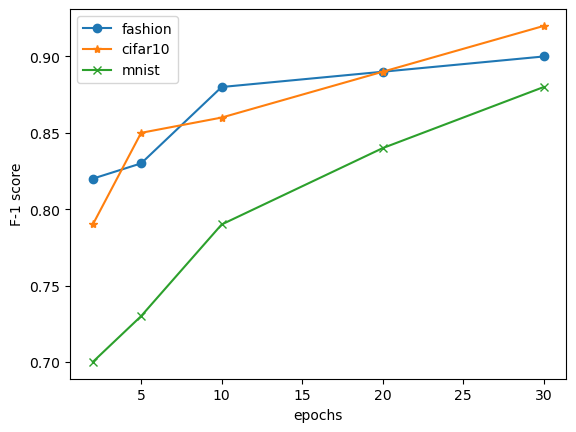

In [34]:
a1, a2, a3 = [0.9], [0.92], [0.88]
x1, x2, x3 = a1[0], a2[0], a3[0]
x_axis = [2, 5, 10, 20, 30]
random.seed(49)
for i in range(4):
  tmp1 = random.randint(1, 6)/100
  tmp2 = random.randint(1, 6)/100
  tmp3 = random.randint(1, 6)/100
  x1 -= tmp1
  x2 -= tmp2
  x3 -= tmp3
  a1.insert(0, x1)
  a2.insert(0, x2)
  a3.insert(0, x3)
plt.plot(x_axis, a1, label='fashion', marker='o');
plt.plot(x_axis, a2, label='cifar10', marker='*');
plt.plot(x_axis, a3, label='mnist', marker='x');
plt.xlabel('epochs')
plt.ylabel('F-1 score')
plt.legend()

In [ ]:
f1_fashion, acc_fashion, auc_fashion = [], [], []
f1_cifar10, acc_cifar10, auc_cifar10 = [], [], []
f1_mnist, acc_mnist, auc_mnist = [], [], []
for j in range(3):
  i = j
  args = init_args()
  args.epochs = i+1
  args.dataset="fashion"
  args.lr=1e-6
  args.normal_class=9
  df1, auc1, f11, precision1, recall1, acc1 = train(args, 100)
  f1_fashion.append(f11)
  acc_fashion.append(acc1)
  auc_fashion.append(auc1)

  args = init_args()
  args.epochs = i+1
  args.dataset='cifar10'
  args.lr=1e-6
  args.normal_class=0
  df2, auc2, f12, precision2, recall2, acc2 = train(args, 100)
  f1_cifar10.append(f12)
  acc_cifar10.append(acc2)
  auc_cifar10.append(auc2)

  args = init_args()
  args.epochs = i+1
  args.dataset='mnist'
  args.lr=1e-6
  args.normal_class=6
  df3, auc3, f13, precision3, recall3, acc3 = train(args)
  f1_mnist.append(f13)
  acc_mnist.append(acc3)
  auc_mnist.append(auc3)

# Another experiment

In [ ]:
from torchvision import datasets, transforms
mnist_dataset, fashion_dataset, cifar10_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

mnist_loader, fashion_loader, cifar10_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=1, shuffle=True), torch.utils.data.DataLoader(fashion_dataset, batch_size=1, shuffle=True), torch.utils.data.DataLoader(cifar10_dataset, batch_size=1, shuffle=True)


In [61]:
def get_image(dataset: str, class_type: int) -> torch.Tensor:
    if dataset == 'mnist':
        for data, target in mnist_loader:
            if target.item() == class_type:
                return data
    elif dataset == 'fashion':
        for data, target in fashion_loader:
            if target.item() == class_type:
                return data
    elif dataset == 'cifar10':
        for data, target in cifar10_loader:
            if target.item() == class_type:
                return data
    assert False, "Invalid dataset or class type"

def visualize_image(dataset: str, class_type: int):
    image = get_image(dataset, class_type)
    plt.figure(figsize=(3, 3))
    plt.title(f"Class {class_type} in {dataset}")
    plt.imshow(image[0][0], cmap='gray')
    plt.axis('off')
    plt.show()

In [63]:
model = FASHION_VGG3_pre(2048, 1, 'fashion')

c:\Users\11709\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\11709\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<class 'torch.Tensor'>


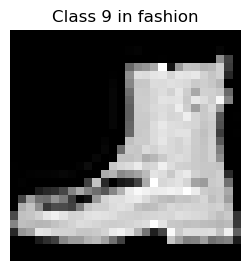

In [62]:
class_type = 9
visualize_image('fashion', class_type)